# Change detection with Log ratio method

In [1]:
# Load the necessary packages
%matplotlib inline

import datacube
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb, plot_lulc

In [3]:
# Connect to the datacube.
dc = datacube.Datacube(app='Forest_Reserves_Time_Series_Analysis')

In [4]:
# Define the area of interest. Northen Tinderet Reserve, Kenya
lat = 0.02
lon = 35.425
buffer = 0.1

# Convert the lat, lon, buffer into a range.
lon_range = (lon - buffer, lon + buffer)
lat_range = (lat - buffer, lat + buffer)


# View the area of interest on an interactive map.
display_map(lon_range, lat_range)

To compare two dates for change detection with the log ratio approach we pick two dates of relative low backscatter (dry conditions) and from similar times of the year (same season in different years).

The dry seasons in Kenya are generally from June to October, and from December to March. 

In [5]:
# The year 2019 is our base year/control sample. 
reference_year = "2019"

# We want to detect the forest changes that occurred from the beginning of 2020 onwards.
change_year = "2020"

# Create a reusable datacube query object for loading data.
query = {
    "y": lat_range,
    "x": lon_range,
    "output_crs": "EPSG:6933",
    "resolution" : (-20,20),
}

print(query)

{'y': (-0.08, 0.12000000000000001), 'x': (35.324999999999996, 35.525), 'output_crs': 'EPSG:6933', 'resolution': (-20, 20)}


In [28]:
# load the Sentinel 1 imagery for the area of interest.
ds_s1 = load_ard(dc=dc,
                 products=["s1_rtc"],
                 measurements=['vv', 'vh'],
                 time=(reference_year, change_year),
                 sat_orbit_state="ascending",
                 group_by="solar_day",
                 dtype='native',
                 **query)

print(ds_s1)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 61 time steps
<xarray.Dataset>
Dimensions:      (time: 61, y: 1277, x: 966)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-09T15:56:25.941116 ... 2020-12...
  * y            (y) float64 1.531e+04 1.529e+04 ... -1.019e+04 -1.021e+04
  * x            (x) float64 3.408e+06 3.408e+06 ... 3.428e+06 3.428e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.09492 0.1015 0.1421 ... 0.1416 0.1396
    vh           (time, y, x) float32 0.02437 0.02622 ... 0.01981 0.03175
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [29]:
# Select the first images n July of 2019 and 2020
ds = ds_s1.sel(time=['2019-07-08T15:56:30.006958000','2020-07-02T15:56:36.219755000'])
ds

<xarray.Dataset>
Dimensions:      (time: 2, y: 1277, x: 966)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-08T15:56:30.006958 2020-07-02T...
  * y            (y) float64 1.531e+04 1.529e+04 ... -1.019e+04 -1.021e+04
  * x            (x) float64 3.408e+06 3.408e+06 ... 3.428e+06 3.428e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.2367 0.2175 0.2006 ... 0.1958 0.2755
    vh           (time, y, x) float32 0.06013 0.02576 0.02258 ... 0.04683 0.0313
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

The Log ratio between the images is 

$r  = log_{10}(\frac{X_i}{X_r})$

$X_i$ new image
$X_r$ reference image

In [30]:
# Get the log ratio betwwen the two images 
r = xr.ufuncs.log10(ds.isel(time=1)/ds.isel(time=0))
r

<xarray.Dataset>
Dimensions:      (y: 1277, x: 966)
Coordinates:
  * y            (y) float64 1.531e+04 1.529e+04 ... -1.019e+04 -1.021e+04
  * x            (x) float64 3.408e+06 3.408e+06 ... 3.428e+06 3.428e+06
    spatial_ref  int32 6933
Data variables:
    vv           (y, x) float32 -0.02509 0.03882 -0.1642 ... -0.1624 -0.001923
    vh           (y, x) float32 -0.103 0.2495 0.3406 ... 0.2665 0.1547 -0.03123

To find a threshold for change, we can display the absolute ration image $abs(r)$ and the historgram of $r$. 

We adjust the scale factors for the display to enhance visualization of change areas with largest backscatter change over the time series. Brighter values show larger change.

In [32]:
abs_r = xr.ufuncs.fabs(r)
abs_r

<xarray.Dataset>
Dimensions:      (y: 1277, x: 966)
Coordinates:
  * y            (y) float64 1.531e+04 1.529e+04 ... -1.019e+04 -1.021e+04
  * x            (x) float64 3.408e+06 3.408e+06 ... 3.428e+06 3.428e+06
    spatial_ref  int32 6933
Data variables:
    vv           (y, x) float32 0.02509 0.03882 0.1642 ... 0.1624 0.001923
    vh           (y, x) float32 0.103 0.2495 0.3406 ... 0.2665 0.1547 0.03123

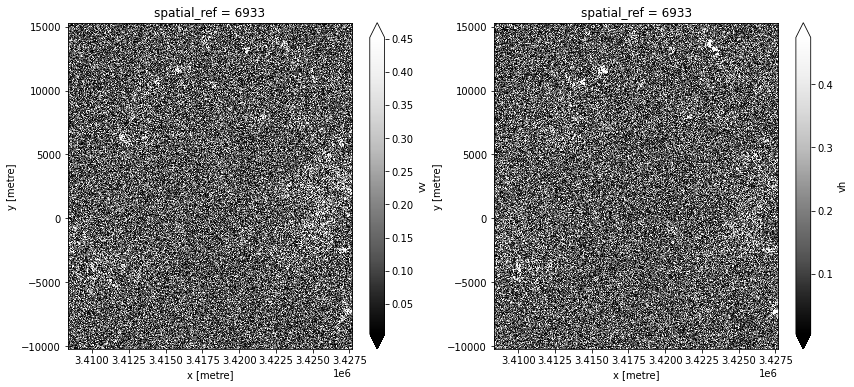

In [36]:
# Plot the absoluter of r.  
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
abs_r['vv'].plot.imshow(cmap="Greys_r", robust=True, ax=ax[0])
abs_r['vh'].plot.imshow(cmap="Greys_r", robust=True, ax=ax[1])
plt.show()

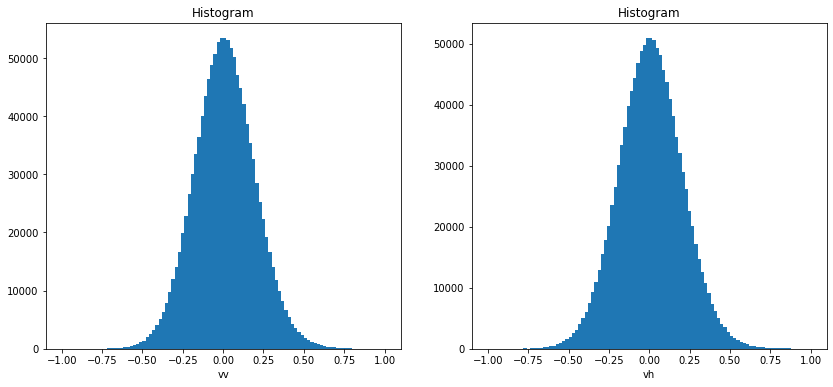

In [42]:
#PLot the r histogram.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
r['vv'].plot.hist(bins=100, ax=ax[0], range=(-1.0,1.0))
r['vh'].plot.hist(bins=100, ax=ax[1], range=(-1.0,1.0))
plt.show()

Let's define change pixels as those falling outside the range of *three* times the standard deviation of the ration image $\sigma_r$ from the image mean $\bar{r}$:

${cp}_{x,y} = (r_{x,y} < \overline{r} - 3\sigma_r) \ \textrm{or} \ (r_{x,y} > \overline{r} + 3\sigma_r)$ 

We are using the numpy masking to set the non-changing pixels inside the range:

In a normal distribution, like the r histograms above, the mean is zero.
Our change pixels will be defined as:

${cp}_{x,y} = (r_{x,y} < - 3\sigma_r) \ \textrm{or} \ (r_{x,y} >  3\sigma_r)$ 

In [91]:
stddev = r.std()
thresh = 3 * stddev 
cp = xr.ufuncs.logical_or((r < -1*(3*stddev)),(r > (3*stddev)))
cp

<xarray.Dataset>
Dimensions:      (y: 1277, x: 966)
Coordinates:
  * y            (y) float64 1.531e+04 1.529e+04 ... -1.019e+04 -1.021e+04
  * x            (x) float64 3.408e+06 3.408e+06 ... 3.428e+06 3.428e+06
    spatial_ref  int32 6933
Data variables:
    vv           (y, x) bool False False False False ... False False False False
    vh           (y, x) bool False False False False ... False False False False

In [94]:
# compare with Global Forest Cover change dataset.
from datacube.testutils.io import rio_slurp_xarray

clipped_tif = "data/clipped_Hansen_GFC-2020-v1.8_lossyear_Mosaic.tif"

# Load raster and reproject to match satellite dataset
gfc = rio_slurp_xarray(fname=clipped_tif, gbox=ds_s1.geobox, resampling="bilinear")

# Get the pixels in the gfc dataset where the lossyear occurred in the post base line period i.e. 16,17,18
validation = xr.where((gfc >= 19), True, False)

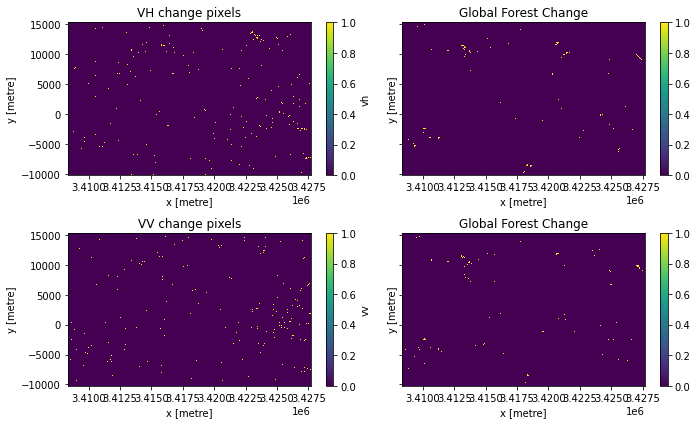

In [95]:
# Compare the sig_deforestation dataset with the validation dataset.
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
cp.vh.plot(ax=ax[0,0])
validation.plot(ax=ax[0,1])
cp.vv.plot(ax=ax[1,0])
validation.plot(ax=ax[1,1])

ax[0,0].set_title("VH change pixels")
ax[0,1].set_title("Global Forest Change")
ax[1,0].set_title("VV change pixels")
ax[1,1].set_title("Global Forest Change")

plt.tight_layout()
plt.show()

In [99]:
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_true = sklearn_flatten(validation)
y_pred = sklearn_flatten(cp.vh)

# Producer's Accuracies.
precision = precision_score(y_true, y_pred, labels=[0, 1], average=None)
precision = precision[1] * 100

# User's Accuracies.
recall = recall_score(y_true, y_pred, labels=[0, 1], average=None)
recall = recall[1] * 100

# Overall Accuracy.
accuracy = accuracy_score(y_true, y_pred, normalize=True)
overall_accuracy = accuracy * 100

# F1 score.
f1score = f1_score(y_true, y_pred)

print(
    "\033[1m" + "\033[91m" + "Deforestation Detection Results"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(overall_accuracy, 2))
print("F1 score: \t", round(f1score, 2))
print("Producer's Accuracy: ", round(precision, 2))
print("User's Accuracy: ", round(recall, 2),)

Deforestation Detection Results

Overall Accuracy:  99.32
F1 score: 	 0.01
Producer's Accuracy:  0.86
User's Accuracy:  1.87


In [100]:
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_true = sklearn_flatten(validation)
y_pred = sklearn_flatten(cp.vv)

# Producer's Accuracies.
precision = precision_score(y_true, y_pred, labels=[0, 1], average=None)
precision = precision[1] * 100

# User's Accuracies.
recall = recall_score(y_true, y_pred, labels=[0, 1], average=None)
recall = recall[1] * 100

# Overall Accuracy.
accuracy = accuracy_score(y_true, y_pred, normalize=True)
overall_accuracy = accuracy * 100

# F1 score.
f1score = f1_score(y_true, y_pred)

print(
    "\033[1m" + "\033[91m" + "Deforestation Detection Results"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(overall_accuracy, 2))
print("F1 score: \t", round(f1score, 2))
print("Producer's Accuracy: ", round(precision, 2))
print("User's Accuracy: ", round(recall, 2),)

Deforestation Detection Results

Overall Accuracy:  99.32
F1 score: 	 0.01
Producer's Accuracy:  0.93
User's Accuracy:  2.02


Not a great change detection method.